In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import math
import cv2

In [2]:
def single_basis(n, t, offset, t_p, t_, A=1):
    return 2*A/n/math.pi*np.sin(n*math.pi*t_p/t_)*np.cos(2*math.pi*n/t_*(t-offset))

def multi_basis(n, t, offset, t_p, t_, A=1):
    a0 = A*t_p/t_
    x_t = np.zeros(len(t))
    for i in range(n):
        x_t += single_basis(i+1, t, offset, t_p, t_, A=1)
    return x_t+a0

t_king = 150 #* Total period
t_p_king = 45 #* Pulse width
A = 1 #* Amplitude
cutoff = 5 #* Number of F series
x_offset = -np.random.rand()*t_ #* Offset
t = np.linspace(0, 400, 5000) #* Time
# a0 = A*t_p/t_

# x_t_5 = multi_basis(5, t, x_offset, t_p, t_, A)
x_t_50 = multi_basis(50, t, x_offset, t_p_king, t_king, A)
# plt.plot(t, x_t_5)
plt.plot(t, x_t_50)

NameError: name 't_' is not defined

$$x_T(t) = \sum_{n=1}\frac{2A}{n\pi}sin(n\pi\frac{t_p}{T})cos(\frac{2\pi n}{T}(t)) + A\frac{T_p}{T}\ \ (T, T_P) \in INUI\ signal \tag{1}$$

$$t = (\epsilon-1/2) T_{I,P} + (\mu+\zeta \sigma) - \eta T_K \tag{2}, \epsilon \in [0,1)$$

$\epsilon$ is the variable for the INUI signal's pulse width, in the **even** condition of wave function, the $t$ should be cut by $1/2t_p$.

$\zeta$ defines the confidence interval of the time consumed during my ride from INUI to KING.

$\eta$ is the variable for the deduction.

$$P(|x(t)| < 0.5) \approx 1 \tag{3}$$
<!-- $$a_0 = A\frac{T_p}{T}\ when\ n = 0 \tag{3}$$ -->

In [6]:
time_cost

NameError: name 'time_cost' is not defined

In [5]:
time_cost_n = np.array([
    43.72, 39.19, 40.82, 36.23, 34.09, 27, 25.16, 23.90,
]) + 3*60

time_cost_d = np.array([
    15.78, 31.12, 21.26, 30.28, 34.89, 11.34, -12.43, -4.11, 11.95, 18.04, 21.72,
]) + 3*60

mu_n = np.mean(time_cost_n)
sigma_n = np.std(time_cost_n, ddof=0)
min_sigma_n, max_sigma_n = np.min((time_cost_n-mu_n)), np.max((time_cost_n-mu_n))
print(f"mu in night: {mu_n}, sigma in night: {sigma_n}")

mu_d = np.mean(time_cost_d)
sigma_d = np.std(time_cost_d, ddof=0)
min_sigma_d, max_sigma_d = np.min((time_cost_d-mu_d)), np.max((time_cost_d-mu_d))
print(f"mu in day: {mu_d}, sigma in day: {sigma_d}")

mu in night: 213.76375000000002, sigma in night: 7.085345682286784
mu in day: 196.34909090909093, sigma in day: 13.828217169347779


In [7]:
time_cost_n_debias = time_cost_n - (mu_n-mu_d)
time_cost = np.concatenate([time_cost_n_debias, time_cost_d])
mu, sigma, min_sigma, max_sigma = mu_d, sigma_d, min_sigma_d, max_sigma_d

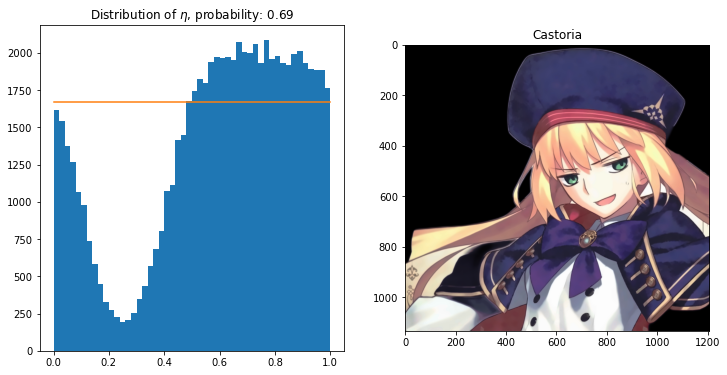

In [9]:
def single_basis(n, t, offset, t_p, t_, A=1):
    return 2*A/n/math.pi*np.sin(n*math.pi*t_p/t_)*np.cos(2*math.pi*n/t_*(t-offset))

def multi_basis(n, t, offset, t_p, t_, A=1):
    a0 = A*t_p/t_
    try:
        x_t = np.zeros(len(t))
    except:
        x_t = 0

    for i in range(n):
        x_t += single_basis(i+1, t, offset, t_p, t_, A=1)
    return x_t+a0

def epsilon(p):
    '''
    probability *p*: start from beginning of green light;
    else: start from random point during green light.
    '''
    epsilon_ = np.random.rand()
    if epsilon_ < p:
        return 0
    else:
        return np.random.rand()

def mu_sigma():
    while 1:
        sigma_samp = np.random.randn()*sigma
        if sigma_samp < max_sigma and sigma_samp > min_sigma:
            break

    return mu + sigma_samp

t_p_inui = 25
t_p_king, t_king = 46, 150
n_sample = 100000
count_red = 0 #* Number of cases for meeting with the real condition.
eta_list, time_cost_list = [], []

#* For fourier series
cutoff = 50
threshold = 0.5

for i in range(n_sample):
    epsilon_ = epsilon(0.5)
    time_cost = mu_sigma()
    eta = np.random.rand() #* Treated as offset term on 1D dimension.
    t_king_reach = (epsilon_-1/2)*t_p_inui + time_cost
    offset_ = eta*t_king

    signal_ = multi_basis(cutoff, t_king_reach, offset_, t_p_king, t_king, A=1)
    signal_ = signal_ <= threshold
    if signal_:
        count_red += 1
        eta_list.append(eta)
    
    time_cost_list.append(time_cost)

bins = 50
eta_list = np.array(eta_list)
# print(f"Probability: {count_red/n_sample}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
(n_info, bins_info, patches_info) = ax1.hist(eta_list, bins=bins)
ax1.plot(np.linspace(0, 1, 100), np.ones(100)*n_sample/bins*(1-1/(300/bins))) #* Dist of zeta

castoria = cv2.imread('./alpha_045.png')
castoria = cv2.cvtColor(castoria, cv2.COLOR_BGR2RGB)
# ax2.hist(time_cost_list) #* Dist of time consumed.
ax2.imshow(castoria)

ax1.set_title("Distribution of $\eta$, probability: {:.2f}".format(count_red/n_sample))
ax2.set_title("Castoria")

plt.show()

In [10]:
count_fact_threshold = n_sample/bins*(1-1/(300/bins))
ind_chosen = np.where(n_info < count_fact_threshold)[0]
eta_count = bins_info[ind_chosen]
eta_count

array([4.48612743e-05, 2.00439085e-02, 4.00429558e-02, 6.00420030e-02,
       8.00410503e-02, 1.00040098e-01, 1.20039145e-01, 1.40038192e-01,
       1.60037239e-01, 1.80036287e-01, 2.00035334e-01, 2.20034381e-01,
       2.40033428e-01, 2.60032476e-01, 2.80031523e-01, 3.00030570e-01,
       3.20029617e-01, 3.40028665e-01, 3.60027712e-01, 3.80026759e-01,
       4.00025806e-01, 4.20024854e-01, 4.40023901e-01, 4.60022948e-01])

That's to say, if $\eta$ is randomly distributed, then around 40% conditions is counterfactual.

Next part: deduce the **distribution** of phase difference.

last for 4h -> 14400s, 

State: $t_{king} = t - \eta T_{king},\ t_{inui} = t$

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  9., 11., 10.,  0.,  0.,  0.,  0.,
         1., 11., 11., 10., 11., 11., 11.]),
 array([-0.44966443, -0.37751678, -0.30536913, -0.23322148, -0.16107383,
        -0.08892617, -0.01677852,  0.05536913,  0.12751678,  0.19966443,
         0.27181208,  0.34395973,  0.41610738,  0.48825503,  0.56040268,
         0.63255034,  0.70469799,  0.77684564,  0.84899329,  0.92114094,
         0.99328859]),
 <BarContainer object of 20 artists>)

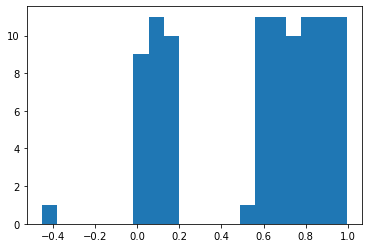

In [8]:
def find_closest(x1, x2, t):
    eta_list, closest_list = [], []
    for i in x1:
        idx = np.searchsorted(x2, i)
        if idx > 0 and idx < len(x2):
            closest = x2[idx] if abs(x2[idx] - i) < abs(x2[idx-1] - i) else x2[idx-1]
        elif idx == 0:
            closest = x2[idx]
        else:
            closest = x2[idx-1]

        diff = i - closest
        if diff > 0:
            eta = 1 - diff/t
        elif diff <= 0:
            eta = -diff/t
        
        closest_list.append(i-closest)
        eta_list.append(eta)
    return eta_list, closest_list

t_inui, t_king = 150, 149
period_inui, period_king = 14400//t_inui, 14400//t_king
x_inui = np.linspace(0,period_inui*t_inui,period_inui+1)
x_king = np.linspace(0,period_king*t_king,period_king+1)-120

eta_list, closest_list = find_closest(x_inui, x_king, t_king)
plt.hist(eta_list, bins=20)